# FMA: A Dataset For Music Analysis

Kirell Benzi, Michaël Defferrard, Pierre Vandergheynst, Xavier Bresson, EPFL LTS2.

## Usage

1. Download dataset from <https://github.com/mdeff/fma>.
2. Uncompress the archive, e.g. with `unzip fma_small.zip`.
3. Load and play with the data in this notebook.

In [1]:
%matplotlib inline

import utils
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import IPython.display as ipd
import os.path

In [2]:
DATA_DIR = os.environ.get('DATA_DIR')
df = pd.read_json(os.path.join(DATA_DIR, 'fma_small.json'))
path = utils.build_path(df, DATA_DIR)

## 1 Metadata

The metadata table, a JSON file in the root directory of the archive, is composed of many colums:
1. The index is the ID of the song, taken from the FMA, used as the name of the audio file.
2. Meta-data from the Free Music Archive website (4 columns).
3. A column to indicate if the song is part of the training or testing set.
4. For the `small` and `medium` datasets, data colected from the [Echonest](http://the.echonest.com/) API:
    1. Meta-data (5 columns).
    2. Temporal features: one vector per song.
    3. Audio features (8 columns).
    4. Social features (5 columns).
    5. Rankings (5 columns).

In [3]:
ipd.display(df[utils.FMA_METADATA].head())
ipd.display(df[utils.ECHONEST_METADATA].head())
ipd.display(df[utils.ECHONEST_AUDIO_FEATURES].head())
ipd.display(df[utils.ECHONEST_SOCIAL_FEATURES].head())
#ipd.display(df[utils.ECHONEST_RANKS].head())

,artist,title,genres,play_count
100538,Rob Rob Rob,Tiger Hunt,"[Electronic, Instrumental]",3681
100540,Rob Rob Rob,Oldtown Break,"[Electronic, Instrumental]",6921
10059,Aviv Mark,The Good Life,"[Rock, Punk]",202
10060,Aviv Mark,Sacrifice,"[Rock, Punk]",231
10082,MC Firedrill,Superbuttontheme_2,[Electronic],134


,release,artist_location,artist_name,album_date,album_name
100538,Downtown EP,{},Rob Rob Rob,None,None
100540,Downtown EP,{},Rob Rob Rob,None,None
10059,Uncontrollable Mumbles,"{'latitude': 32.0451, 'location': 'Tel Aviv, T...",Aviv Mark,None,None
10060,Uncontrollable Mumbles,"{'latitude': 32.0451, 'location': 'Tel Aviv, T...",Aviv Mark,None,None
10082,Untitled,{},MC Firedrill,None,None


,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence
100538,0.697128,0.292255,0.503569,0.944012,0.128878,0.040784,120.053,0.073568
100540,0.251951,0.766093,0.841820,0.936575,0.121031,0.060520,140.037,0.242088
10059,0.675661,0.427170,0.321356,0.946483,0.100299,0.039322,112.537,0.039987
10060,0.093860,0.474643,0.221992,0.801964,0.091354,0.046965,120.853,0.056124
10082,0.992734,0.743704,0.277693,0.277609,0.104902,0.043466,131.833,0.738758


,artist_discovery,artist_familiarity,artist_hotttnesss,song_hotttnesss,song_currency
100538,0.248119,0.068668,0.259205,0.070134,0.0005
100540,0.248119,0.068668,0.259205,0.000000,0.0005
10059,0.066915,0.141195,0.069905,0.000000,0.0000
10060,0.066915,0.141195,0.069905,0.000000,0.0000
10082,0.106328,0.066428,0.111079,0.000000,0.0000


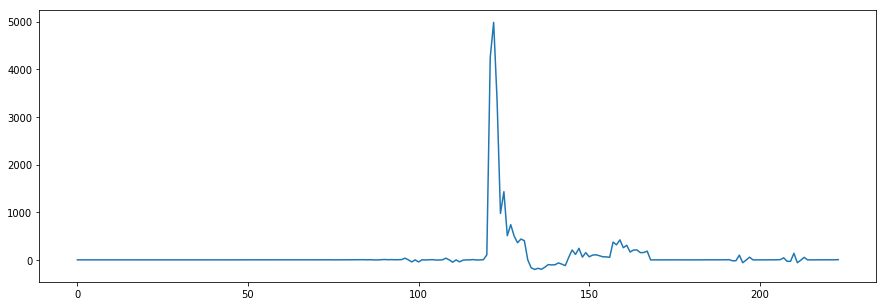

In [4]:
x = df.loc[10060, utils.ECHONEST_TEMPORAL_FEATURES]
plt.figure(figsize=(15, 5))
plt.plot(x);

# 2 Audio

You can listen to an audio excerpt with the below code.

In [5]:
filename = path(0)
print('File: {}'.format(filename))
ipd.Audio(filename)

File: ../fma_small/Electronic/100538.mp3


And use [librosa](https://github.com/librosa/librosa) to extract the raw waveform and compute audio features.

Duration: 30.00s, 661560 samples


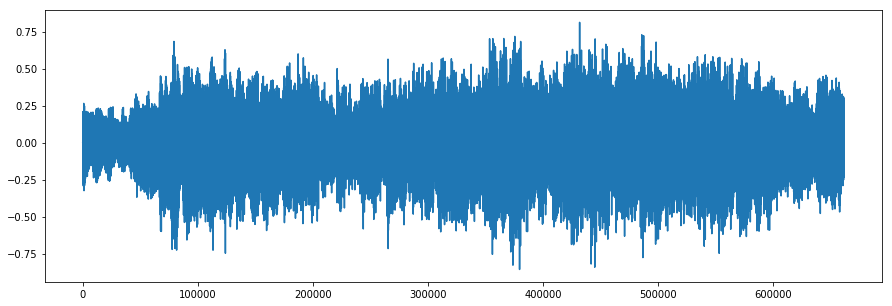

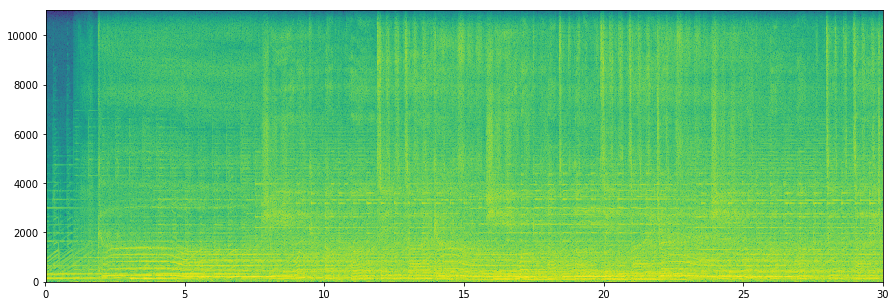

In [6]:
x, sr = librosa.load(filename)
print('Duration: {:.2f}s, {} samples'.format(x.shape[0] / sr, x.size))
ipd.display(ipd.Audio(data=x, rate=sr))

plt.figure(figsize=(15, 5))
plt.plot(x)

plt.figure(figsize=(15, 5))
S, freqs, bins, im = plt.specgram(x, NFFT=1024, Fs=sr, noverlap=512)

## 3 Genre classification

### 3.1 From Echonest features

In [7]:
# Select features.
features = utils.ECHONEST_AUDIO_FEATURES + utils.ECHONEST_SOCIAL_FEATURES

# Discard songs with NaN Echonest features.
# TODO: fix dataset.
keep = df[features].isnull().apply(lambda x: not x.any(), axis=1)
df = df[keep]

X = df[features].as_matrix()
y = df.top_genre.as_matrix()

In [8]:
train = df['train'] == True

y_train = y[train]
y_test = y[~train]
X_train = X[train]
X_test = X[~train]

print('{} training examples, {} testing examples'.format(y_train.size, y_test.size))
print('{} features, {} classes'.format(X_train.shape[1], np.unique(y_train).size))

3078 training examples, 772 testing examples
13 features, 10 classes


In [9]:
# Standardize features by removing the mean and scaling to unit variance.
scaler = StandardScaler(copy=False)
scaler.fit_transform(X_train)
scaler.transform(X_test)

# Support vector classification.
clf = SVC()
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
print('Accuracy: {:.2f} %'.format(score*100))

Accuracy: 31.99 %


### 3.2 From raw audio

### 3.3 From hand-crafted audio features